<a href="https://colab.research.google.com/github/viriditass/Paper-Review/blob/main/WaveNet_A_Generative_Model_for_Raw_Audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WaveNet: A Generative Model for Raw Audio**

논문 링크: https://arxiv.org/abs/1609.03499

본 논문은 2016년도에 Google의 deepmind로부터 발표된 논문이다.

본 논문이 나올 시기 대부분의 TTS 모델들은 **Concatenative TTS**를 기반으로 구현이 되어있었다. (Concatenative TTS는 녹음된 음성 데이터를 쪼개고 조합해서 음성을 생성하는 방식이다.)

Concatenative TTS은 한계점이 명확했는데,
- 많은 양의 데이터가 필요하다.
- 화자나 톤을 바꾸는 등의 변형을 시도할 경우, 그에 따른 새로운 데이터가 또 필요하다.

위에 두 가지 한계점 때문에 이를 보완하기 위해 통계적인 방법으로 음성을 생성하는 방식인 **Parametric TTS**이 주목되었다. 다만, 기존 방식에 비해 생성된 음성이 부자연스러웠다.

이런 한계점들을 해결하기 위해 나온 것이 바로 **WaveNet**이다.

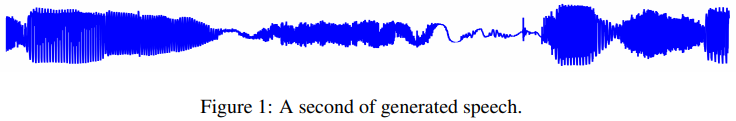

## **WaveNet 구조**

WaveNet은 t 시점의 audio sample을 t-1 시점까지의 sample들의 조건부 분포로 모델링을 한다.

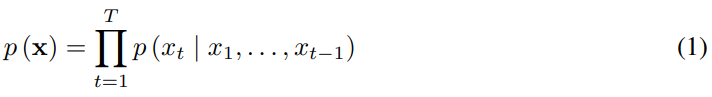

수식은 위와 같다. **즉, 각 sample x_i의 확률 분포는 미래의 sample이 아닌 오직 이전의 sample에만 의존하여 결정이 된다는 것**이다.

### **Dilated causal convolutions**

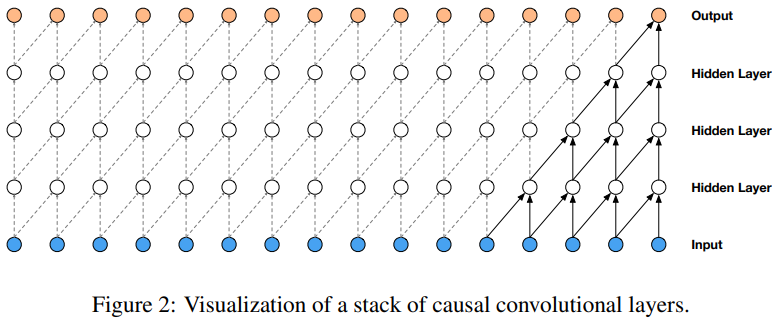

WaveNet은 위의 그림 Figure 2와 같이 오직 과거의 파형 정보만 접근할 수 있도록 causal convolutional layer를 여러겹 쌓는다. 실제 구현시에는 단순히 이전 layer의 결과를 shifting하면서 1d convolution layer를 쌓으면 된다.

Train을 진행할 시에는 GT(ground truth)를 모두 알기 때문에 모든 step에 대한 predict를 동시에 진행할 수 있다(teacher forcing). 음성을 생성할 때는 예측을 한 step씩 진행하게 되고 매 step마다 결과 값은 다음 step의 input 값으로 넣어준다.

이렇게 긴 시계열 데이터를 다룰 때 RNN을 사용하지 않고 causal convolutional layer를 사용하면 모델을 빠르게 train할 수 있다. 하지만, **동일한 dilation의 convolutional layer를 쌓으면 receptive field를 넓히기 위해서 많은 층이 필요하다는 단점**이 있다.

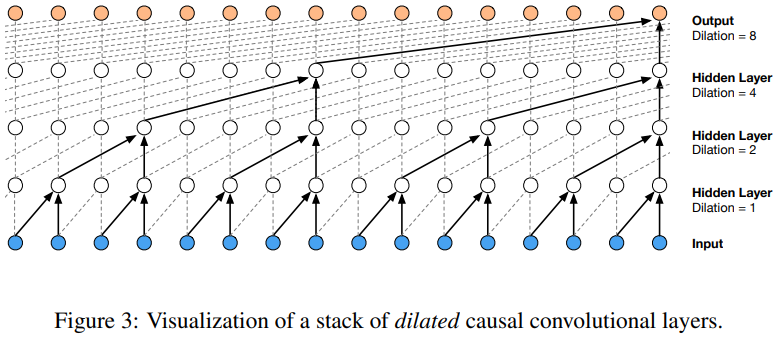

이 단점을 해결하기 위해 WaveNet은 위의 그림 Figure 3과 같이 일정 step을 건너뛰는 dilated convolution을 사용한다. (DeepLab 논문에서 봤던 그 dilated convolution이 맞다.)

위 그림의 경우 dilation이 각각 1, 2, 4, 8인 dilated causal convolution layer를 차례로 쌓은 모습이며 이때 receptive field는 16이 된다.

본 논문에서는 dilation을 일정 제한까지 두 배씩 증가시키고 이를 반복하며 층을 쌓았다. (1, 2, 4...., 256, 512, 1, 2, 4, ..., 512...) 이런 방식을 사용함으로써 지수 scale로 receptive field를 늘리고 모델의 표현력을 증가시켰다.

### **Softmax distribution**

본 논문에서 conditional distribution을 모델링할 때 softmax distribution을 사용했다. 일반적으로 오디오는 16 bit 정수 값으로 저장하기 때문에 그대로 사용하면 step마다 총 65536개의 확률을 다뤄야 한다.

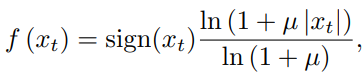

이  수를 줄이기 위해 위의 식과 같이 audio data에 μ-law companding을 적용시켜 256개 중 하나의 값으로 양자화 시켰다. 이러한 non-linear한 양자화 방식이 linear한 방식보다 좋은 성능을 보였다고 한다.

### **Gated activation units**

WaveNet에서는 **PixelCNN**에서 사용된 gated activation unit을 사용한다.

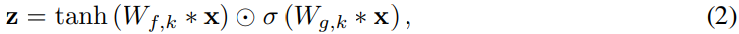

위의 식이 바로 gated activation unit인데, 각 연산과 변수의 의미를 설명해보자면 아래와 같다.
- *: convolution 연산
- ⊙: element-wise 곱셈
- σ(⋅): 시그모이드 함수
- W: 학습 가능한 convolution filter
- f: filter
- g: gate
- k: layer의 번호

매 layer마다 input이 주어지면 filter와 gate에 대한 convolution을 각각 구한 뒤 element-wise 곱을 구한다.

### **Residual and skip connections**

WaveNet은 train시 수렴 속도를 높이고 깊은 모델을 만들기 위해 각 layer마다 residual, skip connection을 사용한다.

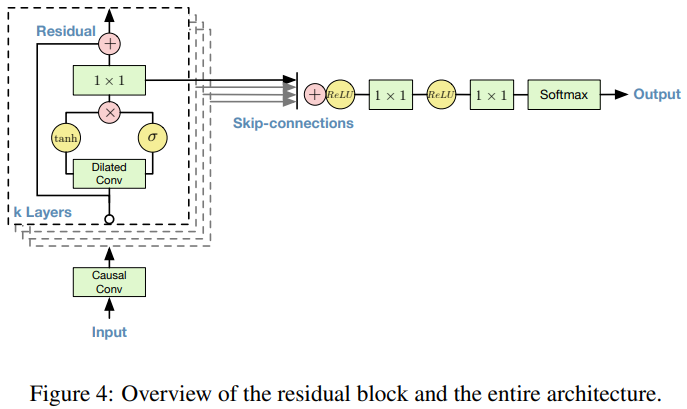

WaveNet의 전체적인 구조는 위의 그림 Figure 4와 같다. gated activation unit을 적용한 뒤 residual에 대한 1x1 convolution과 skip connection에 대한 1x1 convolution을 따로 구했다.

### **Conditional WaveNets**

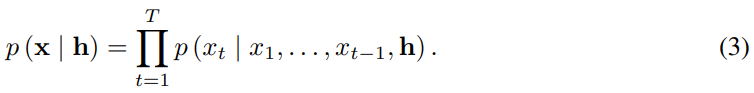

WaveNet은 조건 h가 주어졌을 때 조건부 확률인 p(x | h)를 위의 식과 같이 모델링할 수 있다.

이런식으로 조건을 추가함으로써 WaveNet은 특별한 성징을 가진 audio를 생성할 수 있는데, 여러 명의 화자에 대한 음성 데이터가 주어졌다면 화자에 대한 정보를 조건으로 설정하여 각 화자에 대한 음성을 들을 수 있다. 만일 TTS의 경우 text에 대한 정보가 필요하기 때문에 이를 조건으로 설정해 모델을 학습하면 된다.

WaveNet의 조건을 설정하는 방식의 경우 아래와 같이 2가지가 있다.
1. global conditioning
2. local conditioning

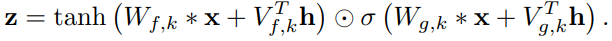

첫 번째 방식인 전역전인 방법을 사용하면 주어진 조건 정보가 모든 step에 동일한 영향을 준다. 이때, 앞에서 설명한 activation function은 위의 식과 같이 변하게 된다. 이 식에서 V는 학습 가능한 linear projection을 나타낸다.

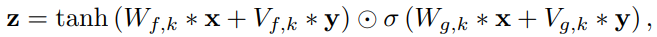

두 번째 방식은 지역적인 방법은 조건이 시계열 h_t로 주어졌을 때 사용할 수 있다. 예를 들면 TTS의 경우 **linguistic features** 혹은 **text embedding**이 있다. 

h_t를 activation function에 적용하기 위해선 h_t의 time step 수를 audio의 time step와 동일하게 맞춰줘야 하는데, 이를 위해 transposed convolution을 사용하거나 혹은 단순히 각 step을 복제해 맞춰준다. 스탭 수를 맞춰준 조건 정보를 y = f(h)라고 할 때 activation function은 위의 식과 같이 변하게 된다.

## **Experiments**

실험의 경우 VCTK dataset(English multi-speaker corpus)를 사용해 다양한 화자의 ID를 조건으로 추가해 WaveNet 모델로부터 각 화자의 특징을 포함한 음성을 생성할 수 있는지 테스트했다. 화자의 ID는 One-hot vector로 변환 후 train시 추가적인 정보로 입력을 해주었다.

WaveNet을 이용해 TTS를 진행하기 위해 추가해야 하는 정보는 **음소, 음소 길이, 기본 주파수 F_0** 등이 있다. 즉, train시 이 정보들을 모두 추가해 진행한 뒤 생성할 때는 조건 정보만을 이용해 음성을 생성한다.

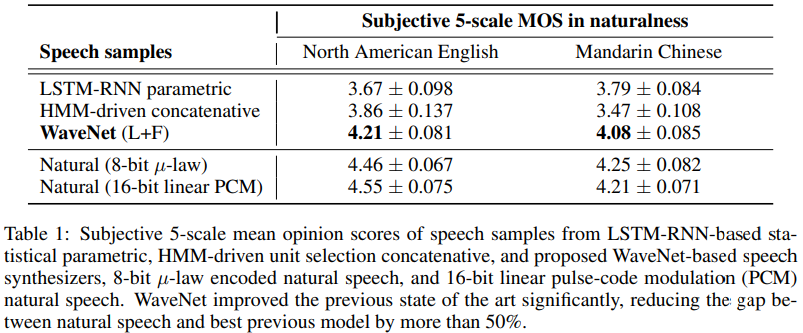

위의 표 Table 1은 TTS task에서 WaveNet의 성능을 평가하기 위해 LSTM-RNN과 HMM(Hidden Markov Model)과 비교를 한 것이다. 이때, WaveNet(L)은 **Linguistic features(음소, 음소 길이)**를 조건 정보로 추가한 것이고, WaveNet(L+F)는 Linguistic features 뿐만 아니라 기본주파수에 log scale을 진행한 log F_0을 추가해 학습했다.

평가 방법은 총 2가지인데, 아래와 같다.
1. **Paired Comparison Test**: 피실험자에게 두 개의 실험 모델로부터 생성된 음성을 들려준 뒤, 더 좋은 음성을 선택하는 것
2. **Mean Opinion Socre(MOS) Test**: 피실험자에게 실험 모델로부터 생성된 음성을 들려주고 1~5 점의 품질 점수를 선택하는 것

MOS test에서 WaveNet의 성능이 압도적으로 좋은 것을 볼 수 있다.

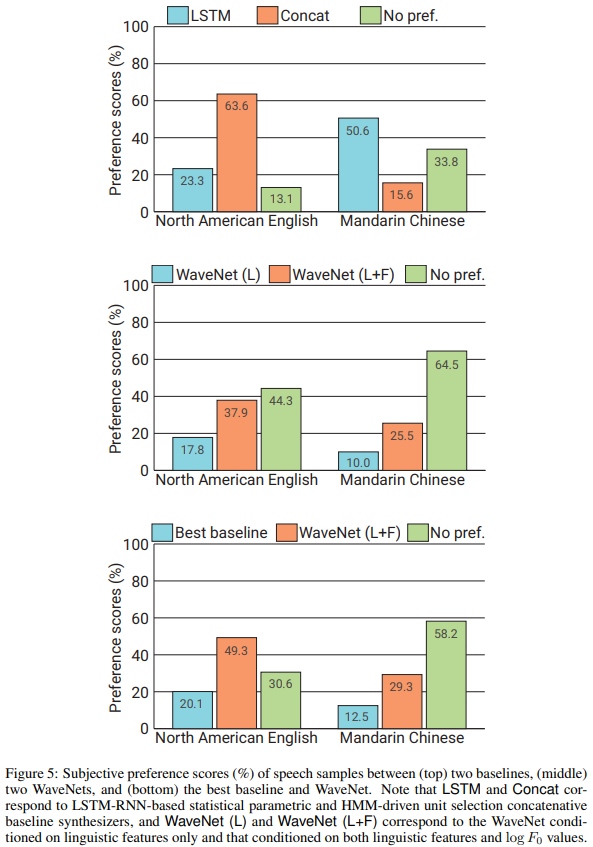